In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Introduction
- We use three Keras functionalities (inherits from keras model) to train, evaluate and pedict from the model that developed
    - Model.fit() - for training
    - Model.evaluate() - to evaluate the model
    - Model.predict() - to infere the model on test example or test dataset
- When we use built in loops for training and evaluation, process will be same for both Seqential and Functional API models

## A First end -to-end Example
- Data can be fed to training loops either using
    - Numpy Arrays (When the data is small and can be fit into memory)
    - tf.data Dataset objects

Lets consider the following model for MNIST classification:

A Typical end-to-end workflow looks like consists of:
- Training
- Validation on Hold out Data (generated from original training data)
- Evaluation on Test Data


In [2]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense1")(inputs)
x = layers.Dense(64, activation="relu", name="dense2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictio")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1,784).astype("float32")/255
x_test = x_test.reshape(-1,784).astype("float32")/255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Specify the training configuration (optimizser, loss, metrics)
model.compile(optimizer = keras.optimizers.RMSprop(),
              loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics = [keras.metrics.SparseCategoricalAccuracy()],)

# fit() is for training the model with several parameters
print("Training The Model...")
history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_data=(x_val, y_val))

Training The Model...
Epoch 1/2
782/782 [==============================] - 6s 6ms/step - loss: 0.3399 - sparse_categorical_accuracy: 0.9037 - val_loss: 0.2210 - val_sparse_categorical_accuracy: 0.9344
Epoch 2/2
782/782 [==============================] - 4s 5ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.1284 - val_sparse_categorical_accuracy: 0.9629


In [4]:
# history object holds the metrics and losses for each epoch of both training and validation data
history.history

{'loss': [0.33990928530693054, 0.15498098731040955],
 'sparse_categorical_accuracy': [0.9037399888038635, 0.9538400173187256],
 'val_loss': [0.22100581228733063, 0.12841889262199402],
 'val_sparse_categorical_accuracy': [0.9344000220298767, 0.9628999829292297]}

In [5]:
# Evaluate the model on the test data using "evaluate" method
print("Evauae on Test Data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)
# Get predictions on individual images or batch of images using predict method
print("Generate Predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape", predictions.shape)

Evauae on Test Data
79/79 [==============================] - 0s 4ms/step - loss: 0.1338 - sparse_categorical_accuracy: 0.9610
test loss, test acc: [0.13381463289260864, 0.9610000252723694]
Generate Predictions for 3 samples
1/1 [==============================] - 0s 193ms/step
predictions shape (3, 10)


## Compiling a Model: Loss, Metrics, Optimizer
To train a model before going to fit() we need to compile the model with following fields
- optimizer - Algorithm for Backpropogation (example: Adam, RMSProp, Adagrad,...etc)
- loss - If the model have multiple outputs then we can specify different loss functions for each output
- metrics - its list of where we can specify any number of metrics. and also for multi output model we can specify multiple types of metrics

If we want to go with default values for (optimizer, loss and metrics) we can specify them in strings. if we want to customize them we need to call respective functions from keras


In [6]:
# Model compilation with default fileds
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [7]:
# Model compilation with custom functions
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [8]:
# For later reuse, let's put our model definition and compile step in functions; we will call them several times across different examples in this guide.
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

### Builtin Optimizers, Losses and Metircs
Optimizers: tf.keras.optimizers.
- SGD() (with or without momentum)
- RMSProp()
- Adam()
- Adagard()
- Adadelta()
- Adamax()

Losses: tf.keras.losses.
- BinaryCrossentropy()
- CategoricalCrossentropy()
- CategoricalHinge()
- CosineSimilairty()
- Hinge()
- KLDivergence()
- MeanAbsoluteError()
- MeanAbsolutePercentageError()
- MeanSquaredError()
- MeanSquaredLogarithmicError()
- SparseCategoricalCrossentropy()

Metrics: tf.keras.metrics.
- AUC()
- Precision()
- Recall()
- Accuracy()

Apart from there if we want to create a custom functions Keras has the feasability to create

### Custom Loss:
To create a custom loss function we can do it in two ways
- create a function which takes y_true and y_pred as inputs (it wont accept other inputs)
- if we want to have other paramters along with y_true and y_pred we need to create a custom loss class inherited from tf.keras.losses.Loss



In [9]:
# The following example shows a loss function that computes the mean squared error between the real data and the predictions:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 7s 7ms/step - loss: 0.0160


If you need a loss function that takes in parameters beside y_true and y_pred, you can subclass the tf.keras.losses.Loss class and implement the following two methods:
- __init__(self): accept parameters to pass during the call of your loss function
- call(self, y_true, y_pred): use the targets (y_true) and the model predictions (y_pred) to compute the model's loss

Let's say you want to use mean squared error, but with an added term that will de-incentivize prediction values far from 0.5 (we assume that the categorical targets are one-hot encoded and take values between 0 and 1). This creates an incentive for the model not to be too confident, which may help reduce overfitting (we won't know if it works until we try!).

Here's how you would do it:

In [10]:
class CustomMSE(tf.keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super(CustomMSE, self).__init__(name=name)
        self.regularization_factor = regularization_factor
    def call(self, y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true-y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse+reg*self.regularization_factor

model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)


782/782 [==============================] - 4s 4ms/step - loss: 0.0390


### Custom Metrics:
if we want to create or use any metric which is not a part of API we can create it by using tf.keras.metrics.Metric class. For this we need to implement 4 methods:
- __init__(self) in which we create state variables for our metric
- update_state(self, y_true, y_pred, sample_weight=None) which takes y_true and y_pred to update the sate varaibles
- result(self) which uses the state varaible to compute the result
- reset_state(Self) which reinitializes the state of the metric

State update and result computations kept separately because when the data size used for the results computation is vere huge, it will become computationally very expensive and would be done periodically. So for each period state varaibles will be updated and corresponing results as well

In [11]:
# Here's a simple example showing how to implement a CategoricalTruePositives metric that counts how many samples were correctly classified as belonging to a given class:
class CategoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), (-1,1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives
    
    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)

model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 [==============================] - 5s 5ms/step - loss: 0.3525 - categorical_true_positives: 44985.0000
Epoch 2/3
782/782 [==============================] - 4s 5ms/step - loss: 0.1674 - categorical_true_positives: 47527.0000
Epoch 3/3
782/782 [==============================] - 5s 7ms/step - loss: 0.1225 - categorical_true_positives: 48152.0000


### Handling Losses Metrics that don' fit the standard signature
- Many of losses and metrics can be computed using y_true and y_pred
- But in some cases model output might not be used to compute the loss
- For example a regularization loss may only require the activation of a layer, and this activation may not be a model output.
- In such cases, you can call self.add_loss(loss_value) from inside the call method of a custom layer. 
- Losses added in this way get added to the "main" loss during training (the one passed to compile())

In [12]:
class ActivityRegularizationLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs)*0.1)
        return inputs

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 9s 8ms/step - loss: 2.5014


In [13]:
# You can do the same for logging metric values, using add_metric()
class MetricLoggingLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            tf.keras.backend.std(inputs),name="std_of_activation", aggregation="mean"
        )
        return inputs
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 7s 6ms/step - loss: 0.3432 - std_of_activation: 0.8957


In [14]:
# In the Functional API, you can also call model.add_loss(loss_tensor), or model.add_metric(metric_tensor, name, aggregation).
# Here's a simple example:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 5s 5ms/step - loss: 2.4587 - std_of_activation: 0.0017


Note that when you pass losses via add_loss(), it becomes possible to call compile() without a loss function, since the model already has a loss to minimize.

Consider the following LogisticEndpoint layer: it takes as inputs targets & logits, and it tracks a crossentropy loss via add_loss(). It also tracks classification accuracy via add_metric()

In [15]:
class LogisticEndpoint(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = tf.keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)
        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")
        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)

#you can use it in a model with two inputs (input data & targets), compiled without a loss argument, like this:
inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 1s 1s/step - loss: 0.9386 - binary_accuracy: 0.0000e+00


### Automatically Setting Apart a Validation Holdout Set
- So far we have used validation data set for validating the model while training
- Instead we can split the training data into vaidation while training using validation_split paramters
- But this can be used only when we are using Numpy data for training


In [16]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 5s 6ms/step - loss: 0.3628 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.2265 - val_sparse_categorical_accuracy: 0.9324


## Training and Evaluation from tf.data Datasets
- So far we worked with Numpy array datasets
- Now lets look at the case where our data comes in the form of tf.data.Dataset object.
- The tf.data API is a set of utilities in Tensorflow 2.0 for loading and preprocessing data in a way that's fast and scalable
- We cah pass a Dataset instance directly to the methods fit(), evaluate() and predict():

In [17]:
model = get_compiled_model()
# Lets create a Datset instance on MNIST data 
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# shuffle and slice the datset
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now do the same for test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# since we passed batching in dataset there is no need of providing batch_size in training
model.fit(train_dataset, epochs=3)

# lets evaluate on test dataset
print("Evaluate...")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names,result))


Epoch 1/3
782/782 [==============================] - 5s 5ms/step - loss: 0.3411 - sparse_categorical_accuracy: 0.9026
Epoch 2/3
782/782 [==============================] - 4s 6ms/step - loss: 0.1630 - sparse_categorical_accuracy: 0.9514
Epoch 3/3
782/782 [==============================] - 4s 5ms/step - loss: 0.1198 - sparse_categorical_accuracy: 0.9641
Evaluate...
157/157 [==============================] - 1s 4ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9598


{'loss': 0.12529686093330383,
 'sparse_categorical_accuracy': 0.9598000049591064}

- Dataset will be reset at the end of the each epoch, so that it can be reused in the next epoch. 
- If we want to run only a specific numver of batches for each epoch we can pass the argument steps_per_epoch
- This argument specifies howmany training stpes the model should run using the Dataset before moving on to the next epoch. 
- If we do this the Dataset is not reset at the end of the each epoch, insted we just keep drawing the next batches. 
- The dataset will eventually run outof data (unless it is an infinitely-looping dataset)

In [18]:
model = get_compiled_model()
# prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# only use 1000 vatches per epoch (thats 64*100 samples)
model.fit(train_dataset, epochs=11, steps_per_epoch = 100)

Epoch 1/11
100/100 [==============================] - 2s 6ms/step - loss: 0.8032 - sparse_categorical_accuracy: 0.7845
Epoch 2/11
100/100 [==============================] - 1s 5ms/step - loss: 0.3743 - sparse_categorical_accuracy: 0.8922
Epoch 3/11
100/100 [==============================] - 0s 5ms/step - loss: 0.3244 - sparse_categorical_accuracy: 0.9042
Epoch 4/11
100/100 [==============================] - 0s 5ms/step - loss: 0.2655 - sparse_categorical_accuracy: 0.9253
Epoch 5/11
100/100 [==============================] - 0s 5ms/step - loss: 0.2613 - sparse_categorical_accuracy: 0.9208
Epoch 6/11
100/100 [==============================] - 0s 5ms/step - loss: 0.2261 - sparse_categorical_accuracy: 0.9380
Epoch 7/11
100/100 [==============================] - 1s 6ms/step - loss: 0.2168 - sparse_categorical_accuracy: 0.9347
Epoch 8/11
100/100 [==============================] - 2s 25ms/step - loss: 0.2248 - sparse_categorical_accuracy: 0.9342


In [19]:
model = get_compiled_model()
# prepare the training dataset using repeat function
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat()
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# only use 1000 vatches per epoch (thats 64*100 samples)
model.fit(train_dataset, epochs=11, steps_per_epoch = 100)

Epoch 1/11
100/100 [==============================] - 2s 5ms/step - loss: 0.7838 - sparse_categorical_accuracy: 0.7986
Epoch 2/11
100/100 [==============================] - 0s 5ms/step - loss: 0.3689 - sparse_categorical_accuracy: 0.8966
Epoch 3/11
100/100 [==============================] - 1s 6ms/step - loss: 0.3357 - sparse_categorical_accuracy: 0.9038
Epoch 4/11
100/100 [==============================] - 1s 5ms/step - loss: 0.2673 - sparse_categorical_accuracy: 0.9223
Epoch 5/11
100/100 [==============================] - 0s 5ms/step - loss: 0.2794 - sparse_categorical_accuracy: 0.9177
Epoch 6/11
100/100 [==============================] - 0s 5ms/step - loss: 0.2258 - sparse_categorical_accuracy: 0.9316
Epoch 7/11
100/100 [==============================] - 0s 5ms/step - loss: 0.2201 - sparse_categorical_accuracy: 0.9369
Epoch 8/11
100/100 [==============================] - 0s 5ms/step - loss: 0.2207 - sparse_categorical_accuracy: 0.9314
Epoch 9/11
100/100 [============================

### Using a Validation Dataset
- We can pass a Dataset instance as a validation_data argument in fit():
- At the end of each epoch the model will iterate over the validation dataset and compute the validation loss and validation metrics
- If we want to run validation only on a specific number of batches from this dataset, we can pass the validation_steps argument
- this argument specifies how many validation steps the model should run with the validation dataset before interrupting validation and moving on to the next epoch.
- Note that the validation dataset will be reset after each use even with validation_steps argument (so that you will always be evaluating on the same samples from epoch to epoch).
- The argument validation_split (generating a holdout set from the training data) is not supported when training from Dataset objects, since this feature requires the ability to index the samples of the datasets, which is not possible in general with the Dataset API.

In [20]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 6s 6ms/step - loss: 0.3335 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.2067 - val_sparse_categorical_accuracy: 0.9383


In [21]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)


782/782 [==============================] - 6s 6ms/step - loss: 0.3354 - sparse_categorical_accuracy: 0.9052 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 0.9187


## Uisng tf.keras.uitls.Sequence Object as input
- Besides NumPy arrays, eager tensors, and TensorFlow Datasets, it's possible to train a Keras model using Pandas dataframes, or from Python generators that yield batches of data & labels.
- In particular, the keras.utils.Sequence class offers a simple interface to build Python data generators that are multiprocessing-aware and can be shuffled.
- In general, we recommend that you use:
    - NumPy input data if your data is small and fits in memory
    - Dataset objects if you have large datasets and you need to do distributed training
    - Sequence objects if you have large datasets and you need to do a lot of custom Python-side processing that cannot be done in TensorFlow (e.g. if you rely on external libraries for data loading or preprocessing).


keras.utils.Sequence is a utility that you can subclass to obtain a Python generator with two important properties:
- It works well with multiprocessing.
- It can be shuffled (e.g. when passing shuffle=True in fit()).

A Sequence must implement two methods:
- \_\_getitem\_\_
- \_\_len\_\_

The method __getitem__ should return a complete batch. If you want to modify your dataset between epochs, you may implement on_epoch_end.

Here's a quick example:

In [22]:
# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.
class CIFAR10Sequence(tf.keras.utils.Sequence):
    def __init__(self, filenames, labels, batch_size):
        super(CIFAR10Sequence, self).__init__()
        self.filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
    def __len__(self):
        return len(np.ceil(len(self.filenames)/float(self.batch_size)))
    def __getitem__(self,idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([resize(imread(filename), (200, 200)) for filename in batch_x]), np.array(batch_y)

#sequence = CIFAR10Sequence(filenames, labels, batch_size)
#model.fit(sequence, epochs=10)

## Using sample weighting and class weighting
With the default settings the weight of a sample is decided by its frequency in the dataset. There are two methods to weight the data, independent of sample frequency:
- Class weights
- Sample weights

### Class weights
- This is set by passing a dictionary to the class_weight argument to Model.fit(). 
- This dictionary maps class indices to the weight that should be used for samples belonging to this class.
- This can be used to balance classes without resampling, or to train a model that gives more importance to a particular class.
- For instance, if class "0" is half as represented as class "1" in your data, you could use Model.fit(..., class_weight={0: 1., 1: 0.5}).

Here's a NumPy example where we use class weights or sample weights to give more importance to the correct classification of class #5 (which is the digit "5" in the MNIST dataset).

In [23]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 [==============================] - 5s 5ms/step - loss: 0.3761 - sparse_categorical_accuracy: 0.9011


### Sample weights
For fine grained control, or if you are not building a classifier, you can use "sample weights".
- When training from NumPy data: Pass the sample_weight argument to Model.fit().
- When training from tf.data or any other sort of iterator: Yield (input_batch, label_batch, sample_weight_batch) tuples.

A "sample weights" array is an array of numbers that specify how much weight each sample in a batch should have in computing the total loss. It is commonly used in imbalanced classification problems (the idea being to give more weight to rarely-seen classes).

When the weights used are ones and zeros, the array can be used as a mask for the loss function (entirely discarding the contribution of certain samples to the total loss).

In [24]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 5s 5ms/step - loss: 0.3883 - sparse_categorical_accuracy: 0.8998


In [25]:
# Here's a matching tf.data.Dataset example:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 5s 5ms/step - loss: 0.3874 - sparse_categorical_accuracy: 0.8993


## Passing data to multi-input, multi-output models
In the previous examples, we were considering a model with a single input (a tensor of shape (764,)) and a single output (a prediction tensor of shape (10,)). But what about models that have multiple inputs or outputs?

Consider the following model, which has an image input of shape (32, 32, 3) (that's (height, width, channels)) and a time series input of shape (None, 10) (that's (timesteps, features)). Our model will have two outputs computed from the combination of these inputs: a "score" (of shape (1,)) and a probability distribution over five classes (of shape (5,)).

In [26]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

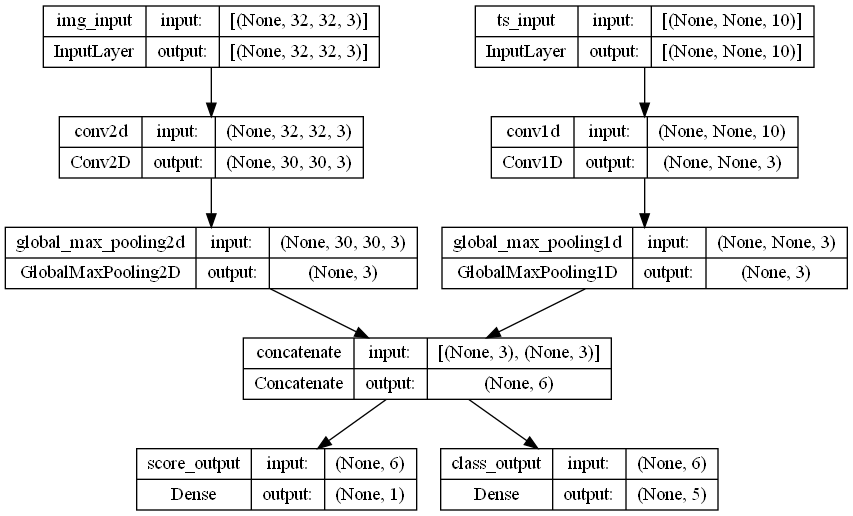

In [27]:
# Let's plot this model, so you can clearly see what we're doing here 
# (note that the shapes shown in the plot are batch shapes, rather than per-sample shapes).
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [28]:
# At compilation time, we can specify different losses to different outputs, by passing the loss functions as a list:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

In [29]:
# If we only passed a single loss function to the model, the same loss function would be applied to every output (which is not appropriate here).
# Likewise for metrics:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

In [30]:
# Since we gave names to our output layers, we could also specify per-output losses and metrics via a dict:
# We recommend the use of explicit names and dicts if you have more than 2 outputs.

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

In [31]:
# It's possible to give different weights to different output-specific losses 
# (for instance, one might wish to privilege the "score" loss in our example, by giving to 2x the importance of the class loss), using the loss_weights argument:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

In [32]:
# You could also choose not to compute a loss for certain outputs, if these outputs are meant for prediction but not for training:


# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

Passing data to a multi-input or multi-output model in fit() works in a similar way as specifying a loss function in compile: you can pass lists of NumPy arrays (with 1:1 mapping to the outputs that received a loss function) or dicts mapping output names to NumPy arrays.

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 2s 8ms/step - loss: 17.4973 - score_output_loss: 0.1501 - class_output_loss: 17.3472


In [34]:
# Here's the Dataset use case: similarly as what we did for NumPy arrays, the Dataset should return a tuple of dicts.

train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 1s 12ms/step - loss: 16.8389 - score_output_loss: 0.1408 - class_output_loss: 16.6981


## Using callbacks